In [1]:
import csv
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from math import sqrt
import analyze
from itertools import chain

In [13]:
# update this file by running pull_states.sh
f = open('data/states-daily.csv')

def get_day(day_raw):
    if day_raw <= 20200331:
        return day_raw - 20200301
    else:
        return 31 + (day_raw - 20200401)

def get_max_day(f):
    reader = csv.DictReader(f)
    max_day = -1
    for row in reader:
        max_day = max(max_day, get_day(int(row['date'])))  
    return max_day

# read through file once to figure out max day
num_cols = get_max_day(f) + 1

# read through file again to actually parse input
f = open('data/states-daily.csv')
reader = csv.DictReader(f)
rows = []

def intsafe(x):
  return int(x) if x != '' else -1
def default():
  return np.zeros(shape=(num_cols,))
tests = defaultdict(default)
hosps = defaultdict(default)
deaths = defaultdict(default)
checked = defaultdict(default)
checked_all = np.zeros(shape=(num_cols,))
for row in reader:  
    day = get_day(int(row['date']))
    state = row['state']
    test_count = intsafe(row['positive'])
    checked_count = intsafe(row['totalTestResults'])
    death_count = intsafe(row['death'])
    hosp_count = intsafe(row['hospitalized'])
    tests[state][day] = test_count
    hosps[state][day] = hosp_count
    deaths[state][day] = death_count
    checked[state][day] = checked_count
    checked_all[day] += checked_count

In [14]:
print(checked["NY"])
print((hosps["NY"]))
print(np.round(np.diff(hosps["NY"])))

[0.00000e+00 0.00000e+00 0.00000e+00 5.40000e+01 9.80000e+01 1.25000e+02
 1.68000e+02 1.97000e+02 2.34000e+02 2.65000e+02 3.08000e+02 3.08000e+02
 3.20000e+03 3.30300e+03 5.27200e+03 5.49300e+03 7.20600e+03 1.45970e+04
 2.22840e+04 3.24270e+04 4.54370e+04 6.14010e+04 7.82890e+04 9.12700e+04
 1.03479e+05 1.22104e+05 1.45753e+05 1.55934e+05 1.72360e+05 1.86468e+05
 2.05186e+05 2.20880e+05 2.38965e+05]
[ 0.0000e+00  0.0000e+00  0.0000e+00 -1.0000e+00 -1.0000e+00 -1.0000e+00
 -1.0000e+00 -1.0000e+00 -1.0000e+00 -1.0000e+00 -1.0000e+00 -1.0000e+00
 -1.0000e+00 -1.0000e+00 -1.0000e+00 -1.0000e+00 -1.0000e+00 -1.0000e+00
 -1.0000e+00 -1.0000e+00  1.6030e+03  1.9740e+03  2.6350e+03  3.2340e+03
  3.8050e+03  6.8440e+03  8.5260e+03  1.0054e+04  1.2075e+04  1.3721e+04
  1.5904e+04  1.8368e+04  2.0817e+04]
[ 0.000e+00  0.000e+00 -1.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.0

In [4]:
def calculate_growth(series, thresh=10, start=5):
  days = np.arange(0, series.shape[0])
  if ((series < thresh).all()):
    return None
  diff = np.diff(np.insert(series, 0, 0))
  keep = (series >= start) & (diff > 0)
  series = series[keep]
  days = days[keep]
  print(series)
  print(days)
  if (days.shape[0] < 3):
    return None
  model = analyze.ExponentialGrowthRateEstimator(family='NegativeBinomial', alpha=0.15)
  model.fit(day=days, cases=series)
  print('True: %s' % np.diff(series))
  print('Pred: %s' % np.round(model.fitted_glm.mu, decimals=1))
  print(model.summary())
  est = model.growth_rate()
  low, high = model.growth_rate_confint()
  return (low, est, high)

In [5]:
growths = dict()
dataset = hosps.items()
for k, v in dataset:
  try:
      print('Calculating results for %s' % k)
      growth = calculate_growth(v, thresh = 20, start = 5)
      if growth:
        growths[k] = growth
  except Exception:
    print('Failed to calculate for %s' % k)

Calculating results for AK
Calculating results for AL
Calculating results for AR
[13. 22. 41. 48. 62. 64. 90.]
[21 23 25 26 29 30 31]
[0.52495844 0.52495844 0.         1.06644572 0.         0.        ]
True: [ 9. 19.  7. 14.  2. 26.]
Pred: [ 5.1  6.5  6.9 11.2 11.1 12.5]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                    6
Model:                            GLM   Df Residuals:                        4
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19.294
Date:                Thu, 02 Apr 2020   Deviance:                       11.589
Time:                        20:25:59   Pearson chi2:                     9.99
No. Iterations:                     6                                         
Covariance Type: 

/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:1230: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid


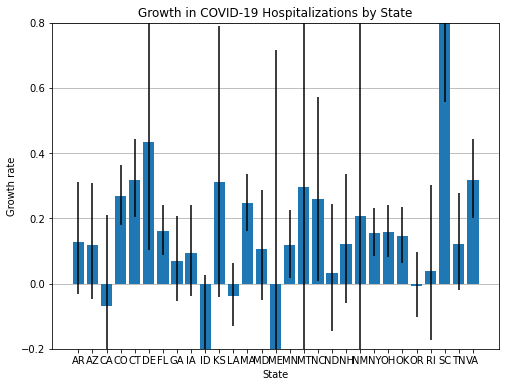

In [6]:
to_plot = growths
names = list(to_plot.keys())
err_l = list([v[1]-v[0] for v in to_plot.values()])
ests  = list([v[1] for v in to_plot.values()])
err_h = list([v[2]-v[1] for v in to_plot.values()])
errs = np.array([err_l, err_h])
plt.rcParams['axes.axisbelow'] = True
plt.bar(range(len(names)), ests, yerr=errs, align='center')
plt.ylim([-0.2,0.8])
plt.grid(axis='y')
plt.xlabel('State')
plt.ylabel('Growth rate')
plt.title('Growth in COVID-19 Hospitalizations by State')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)

plt.xticks(range(len(names)), names)
plt.show()

In [7]:
growths = dict()
dataset = deaths.items()
for k, v in dataset:
  try:
      print('Calculating results for %s' % k)
      growth = calculate_growth(v, thresh = 20, start = 5)
      if growth:
        growths[k] = growth
  except Exception:
    print('Failed to calculate for %s' % k)

Calculating results for AK
Calculating results for AL
[ 6. 13. 26. 32.]
[29 30 31 32]
[0. 0. 0.]
True: [ 7. 13.  6.]
Pred: [9.3 8.7 8.1]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                    3
Model:                            GLM   Df Residuals:                        1
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7.8344
Date:                Thu, 02 Apr 2020   Deviance:                       1.3055
Time:                        20:26:20   Pearson chi2:                     1.42
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0

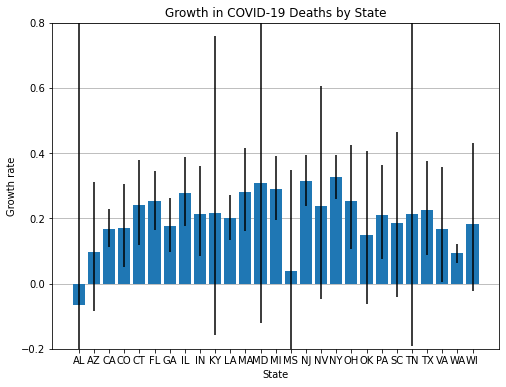

In [8]:
to_plot = growths
names = list(to_plot.keys())
err_l = list([v[1]-v[0] for v in to_plot.values()])
ests  = list([v[1] for v in to_plot.values()])
err_h = list([v[2]-v[1] for v in to_plot.values()])
errs = np.array([err_l, err_h])
plt.rcParams['axes.axisbelow'] = True
plt.bar(range(len(names)), ests, yerr=errs, align='center')
plt.ylim([-0.2,0.8])
plt.grid(axis='y')
plt.xlabel('State')
plt.ylabel('Growth rate')
plt.title('Growth in COVID-19 Deaths by State')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 6)

plt.xticks(range(len(names)), names)
plt.show()

In [9]:
# Growth in number of tests
calculate_growth(checked_all, thresh = 20, start = 100)

[8.660000e+02 1.129000e+03 1.794000e+03 2.150000e+03 2.752000e+03
 3.951000e+03 4.585000e+03 7.124000e+03 9.356000e+03 1.553500e+04
 1.955200e+04 2.572400e+04 4.012300e+04 5.332600e+04 7.395500e+04
 1.008700e+05 1.351800e+05 1.791060e+05 2.253420e+05 2.794730e+05
 3.447120e+05 4.215320e+05 5.193380e+05 6.266330e+05 7.357040e+05
 8.313510e+05 9.448540e+05 1.048884e+06 1.149960e+06 1.267658e+06]
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
True: [   263.    665.    356.    602.   1199.    634.   2539.   2232.   6179.
   4017.   6172.  14399.  13203.  20629.  26915.  34310.  43926.  46236.
  54131.  65239.  76820.  97806. 107295. 109071.  95647. 113503. 104030.
 101076. 117698.]
Pred: [   610.8    770.5    972.    1226.1   1546.7   1951.    2461.2   3104.6
   3916.4   4940.3   6232.    7861.4   9916.9  12509.7  15780.5  19906.4
  25111.1  31676.5  39958

(0.24034983993118209, 0.26145753177186415, 0.28292442441259325)